In [45]:
import pandas as pd
import numpy as np
import re
import string

import nltk
from nltk.corpus import stopwords
# from pattern.es import lemma
from nltk.stem import WordNetLemmatizer

# from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score,train_test_split
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
# plt.figure(figsize=(15,15))
# :rc:`figure.figsize` = ``[6.4, 4.8]``.
plt.rcParams['figure.figsize']=(10,5)


import joblib
from tqdm import tqdm

from statistics import mean
import re
# nltk.download('punkt')
import unicodedata
# nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from spellchecker import SpellChecker
import emoji
import textstat
from wordcloud import WordCloud

In [ ]:
psy=pd.read_csv("Data/YouTubeSpamCollection_FromUCI/Youtube01-Psy.csv")
kp=pd.read_csv("Data/YouTubeSpamCollection_FromUCI/Youtube02-KatyPerry.csv")
lmfao=pd.read_csv("Data/YouTubeSpamCollection_FromUCI/Youtube03-LMFAO.csv")
eminem=pd.read_csv("Data/YouTubeSpamCollection_FromUCI/Youtube04-Eminem.csv")
shakira=pd.read_csv("Data/YouTubeSpamCollection_FromUCI/Youtube05-Shakira.csv")

data=pd.concat([psy,kp,lmfao,eminem,shakira],axis=0,ignore_index=True)
data.to_csv('JoinedTrainingData.csv')
print('This is training data\'s shape :',data.shape)

###  Feature Engineering: 


Meta features - features that are extracted from the text like number of words, number of stop words, number of punctuations etc
Text based features - features directly based on the text / words like frequency, svd, word2vec etc.

#### Length of comments

In [3]:
data['CommentLength']=data['CONTENT'].apply(len)
data.head(2)


,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CommentLength
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1,56
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1,166


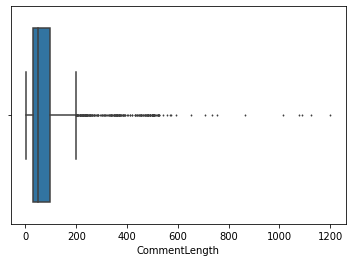

In [4]:
sns.boxplot(x='CommentLength',data=data,fliersize =1);

In [5]:
filt=data['CommentLength']>1000
data.loc[filt,'CONTENT']

303     im sorry for the spam but My name is Jenny. I ...
381     &lt;script&gt;document.write('&lt;a target="_s...
532     http://www.googleadservices.com/pagead/aclk?sa...
1407    This great Warning will happen soon. ,0\nLneaD...
1617    Support the fight for your 4th amendment right...
Name: CONTENT, dtype: object

In [6]:
data.iloc[1407,3]

'This great Warning will happen soon. ,0\nLneaDw26bFst76VHKJL8PxaEy6VMNlvmriUDTSFK6vY,Ali Paša,2013-09-26T22:28:17.047000,Croatia &lt;3,0\nLneaDw26bFvkAHxpKEnM25FYWkyXthsUpri6JuQsZnU,G Belrus,2013-09-26T22:26:12.832000,Nice one,0\nLneaDw26bFtvZQt6JUEhasIEFRJG1exI_dVqdnQVPho,exode. comeback.,2013-09-26T22:23:00.710000,600m views.,0\nLneaDw26bFunOarAg71AwGU6TJO6aZDKFIUn_TZ1_HY,Muhammad Shaeel Abbas,2013-09-26T22:15:45.476000,Fuck off!,0\nLneaDw26bFt-oToUFj0z3vffLFNaxyKwZSIVQhiMx-E,Notorious Niko,2013-09-26T22:00:43.613000,"Hey guys im a 17yr old rapper trying to get exposure... I live in belgium where NO ONE speaks english so i have to resort to this gay SPAM...  Check out my 2 latest tracks as they are probably my best.. Audio isnt the best but im gonna invest in some real equipment for my next track..  Please Thumbs this up so others can see.. or hey dont just check me out yourself and leave a response and a like :D  Thanks in advance, you guys will be part of making my dream come TRUE

Can do >200 as 1 else 0?

####  % of UpperCase letters

In [7]:
# Function to count capital letters
def countCaps(comment):
    count=0
    for c in comment:
        if c.isupper():
            count+=1
    return round(count*100/len(comment),2)
        
        

In [8]:
data['%OfUpperCaseLetters']=data['CONTENT'].apply(countCaps)
data.head(2)

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CommentLength,%OfUpperCaseLetters
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1,56,1.79
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1,166,12.05


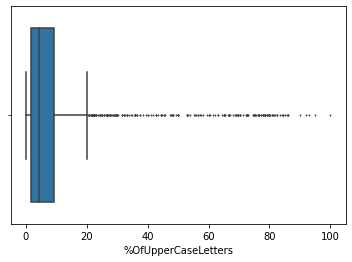

In [9]:
sns.boxplot(x='%OfUpperCaseLetters',data=data,fliersize =1);

####  Find no. of URLs in comments

In [10]:
pattern='(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?'

data['NoOfURL']=data['CONTENT'].apply(lambda x: len(re.findall(pattern,x)))

####  Avg length of each word

In [11]:
def AvgLengthOfEachWord(comment):
    return(round(mean([len(c) for c in comment.split(' ')]),2))

In [12]:
data['AvgLengthOfEachWord']=data['CONTENT'].apply(AvgLengthOfEachWord)

#### No. of stop words in each comment

In [13]:
def NoOfStopWords(comment):
    count=0
    for word in comment:
        if word in stopwords.words('english'):
            count+=1
    return count

In [14]:
data['NoOfStopWords']=data['CONTENT'].apply(NoOfStopWords)

####  No. of sentences in each review

In [15]:
def NoOfSentences(comment):
    return(len(sent_tokenize(comment)))

In [16]:
data['NoOfSentences']=data['CONTENT'].apply(NoOfSentences)

In [17]:
def NoOfWords(comment):
    return(len(word_tokenize(comment)))

In [18]:
data['NoOfWords']=data['CONTENT'].apply(NoOfWords)

####  No. of unique words

In [19]:
def NoOfUniqueWords(comment):
    
    return(len(set(word_tokenize(comment))))

In [20]:
data['NoOfUniqueWords']=data['CONTENT'].apply(NoOfUniqueWords)

In [21]:
data.columns

Index(['COMMENT_ID', 'AUTHOR', 'DATE', 'CONTENT', 'CLASS', 'CommentLength',
       '%OfUpperCaseLetters', 'NoOfURL', 'AvgLengthOfEachWord',
       'NoOfStopWords', 'NoOfSentences', 'NoOfWords', 'NoOfUniqueWords'],
      dtype='object')

In [22]:
data.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CommentLength,%OfUpperCaseLetters,NoOfURL,AvgLengthOfEachWord,NoOfStopWords,NoOfSentences,NoOfWords,NoOfUniqueWords
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1,56,1.79,0,6.12,18,1,13,13
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1,166,12.05,0,4.22,44,3,40,31
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1,38,2.63,0,3.88,16,1,8,8
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,48,0.00,0,3.45,17,1,11,10
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1,39,15.38,0,4.71,10,1,7,7


####  Add features for readability, complexity and grade level (using Textstat library)

In [23]:
data['FleschReadingEase']=data['CONTENT'].apply(lambda x: textstat.flesch_reading_ease(x))

data['GunningFog']=data['CONTENT'].apply(lambda x: textstat.gunning_fog(x))

data['SmogIndex']=data['CONTENT'].apply(lambda x: textstat.smog_index(x))

data['ARI']=data['CONTENT'].apply(lambda x: textstat.automated_readability_index(x))

data['ColemanLiauIndex']=data['CONTENT'].apply(lambda x: textstat.coleman_liau_index(x))

data['TextStandard']=data['CONTENT'].apply(lambda x: textstat.text_standard(x,float_output=True))

data['AvgSentenceLength']=data['CONTENT'].apply(lambda x: textstat.avg_sentence_length(x))

data.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CommentLength,%OfUpperCaseLetters,NoOfURL,AvgLengthOfEachWord,NoOfStopWords,NoOfSentences,NoOfWords,NoOfUniqueWords,FleschReadingEase,GunningFog,SmogIndex,ARI,ColemanLiauIndex,TextStandard,AvgSentenceLength
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1,56,1.79,0,6.12,18,1,13,13,88.74,3.2,0.0,11.4,13.01,3.0,8.0
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1,166,12.05,0,4.22,44,3,40,31,81.63,6.0,0.0,7.3,6.49,6.0,15.0
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1,38,2.63,0,3.88,16,1,8,8,80.28,3.2,0.0,0.8,2.10,4.0,8.0
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,48,0.00,0,3.45,17,1,11,10,78.25,4.0,0.0,1.5,1.54,5.0,10.0
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1,39,15.38,0,4.71,10,1,7,7,83.32,2.0,0.0,12.2,13.08,2.0,5.0


### Clean-up comments

In [24]:
# lemmatize as per part of speech of the word
# It may not be possible manually provide the corrent POS tag for every word for large texts.
# So, instead, we will find out the correct POS tag for each word, map it to the right input character
# that the WordnetLemmatizer accepts and pass it as the second argument to lemmatize().

def lemmatize(cleanTextList):
    
#     Create a dictionary to map POS
    wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
    
#     tag part of speech for each word
    pos_tagged_text = nltk.pos_tag(cleanTextList)
    lemmatizer=WordNetLemmatizer()
    
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

In [25]:
def correct_spellings(wordList):
    spell = SpellChecker()
    corrected_text = []
    
    # find those words that may be misspelled
    misspelled = spell.unknown(wordList.split())
    
    for word in wordList.split():
        if word in misspelled:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return ' '.join(corrected_text)


List of cleaning items:
- Remove URLs
- Remove Emojis
- Convert to lower case
- Remove non-english characters
- Remove stop-words
- Remove punctuations 
- Replace ascent characters
- Lemmatize words
- Correct spelling mistakes


In [26]:
def cleanComment(comment):
    try:
    #   Remove URLS
        pattern='(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?'
        comment=re.sub(pattern,' ',comment)
        
    #   Remove \ufeff    
        comment=comment.replace(u'\ufeff', '')
        
    #   Remove Emojis
        comment=emoji.get_emoji_regexp().sub(r'', comment)
        
    #   turn to lowercase
        comment=comment.lower()
        
    #   Remove non-english words
    #   Reference:https://datascience.stackexchange.com/questions/46705/to-remove-chinese-characters-as-features
        comment = re.sub("([^\x00-\x7F])+"," ",comment)

    #   Tokenize to words
        wordList=word_tokenize(comment)

    #   Remove english stopwords
        wordList=[word for word in wordList if word not in stopwords.words('english')]

    #   Remove punctuations
        wordList=[word for word in wordList if word not in string.punctuation]

    #   Convert ascent characters to their normal english characters
    #   Reference: https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72
        cleanedTextList=[unicodedata.normalize('NFKD',word).encode('ascii', 'ignore').decode('utf-8', 'ignore') \
                  for word in wordList]
        
    #   Lemmatize
        lemmatizedText=lemmatize(cleanedTextList)

    #   Spell Correction
        correctedText=correct_spellings(lemmatizedText)

        return correctedText
    except:
        print(comment)
            

In [ ]:
tqdm.pandas
data['CleanWordList']=data['CONTENT'].progress_apply(lambda x: cleanComment(x))

In [ ]:
data.to_csv('Data/cleanedData.csv',index=False)

In [27]:
data=pd.read_csv('Data/cleanedData.csv')
data.head(2)

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CommentLength,%OfUpperCaseLetters,NoOfURL,AvgLengthOfEachWord,NoOfStopWords,...,NoOfWords,NoOfUniqueWords,CleanWordList,FleschReadingEase,GunningFog,SmogIndex,ARI,ColemanLiauIndex,TextStandard,AvgSentenceLength
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1,56,1.79,0,6.12,18,...,13,13,huh anyway check tube channel kobyoshi02,88.74,3.2,0.0,11.4,13.01,3.0,8.0
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1,166,12.05,0,4.22,44,...,40,31,hey guy check new channel first vid u monkey m...,81.63,6.0,0.0,7.3,6.49,6.0,15.0


In [28]:
data.shape

(1956, 21)

In [29]:
# Drop rows with no comment 
data.dropna(subset=['CleanWordList'],inplace=True)
data.shape

(1906, 21)

In [30]:
data.loc[data['CleanWordList'].isna(),'CleanWordList']

Series([], Name: CleanWordList, dtype: object)

#### Text classification


In [31]:
# Remove Numbers 
# data['CleanWordList']
def removeDigits(comment):
    return re.sub(r'\d+','',comment)
    
data['CleanWordList']=data['CleanWordList'].apply(lambda x:removeDigits(x))

In [32]:
# data.loc[:,'CommentLength':]

In [33]:
X=data['CleanWordList']
y=data['CLASS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=30 ,random_state=147)

countVectorizer=CountVectorizer()

# Create document term matrix for training and testing data
X_train_dtm = countVectorizer.fit_transform(X_train)
X_test_dtm  = countVectorizer.transform(X_test)

#Initialize clasifier
clf=MultinomialNB()

# Initialize Kflod for cross validation
cv = KFold(n_splits=5, random_state=42, shuffle=True)

# Calculate accuracy of training data
scores_trainingData = cross_val_score(clf, X_train_dtm.toarray(),y_train, cv=cv)
print('Training - cross val score:',scores_trainingData.mean())

# Train and predict
clf.fit(X_train_dtm.toarray(),y_train)
prediction=clf.predict(X_test_dtm.toarray())

# Calculate accuracy of class predictions
scores_testingData = cross_val_score(clf, X_test_dtm.toarray(),prediction, cv=cv)
print('Testing - cross val score:',scores_testingData.mean())

Training - cross val score: 0.9040581560283687
Testing - cross val score: 0.6666666666666667


####  Confusion matrix

In [34]:
labels=np.unique(y_test)
labels

array([0, 1], dtype=int64)

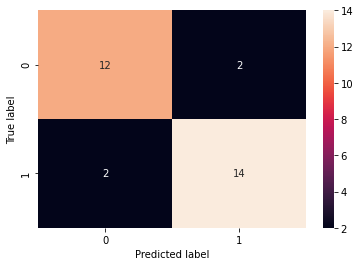

In [35]:
# print the confusion matrix
confusion_matrix=metrics.confusion_matrix(y_test, prediction,labels=labels)


sns.heatmap(confusion_matrix,annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label');

The model is working good for categorizing Hams(0) but struggling to categorize spams(1).


####  Word Cloud 

In [36]:
#Reference: https://github.com/justmarkham/pycon-2016-tutorial/blob/master/tutorial_with_output.ipynb

tokenList=countVectorizer.get_feature_names()
tokenList[:10]

['__',
 '______________________',
 '______________________________',
 '__killuminati',
 '_bzszz',
 '_chris_cz',
 '_ffaaa',
 '_fphgkzllsvdqvzufmb',
 '_gibu',
 '_hmsayho']

In [37]:
hamFeatureCount=clf.feature_count_[0,:].astype(int)
spamFeatureCount=clf.feature_count_[1,:].astype(int)

hamFeatureCount

array([0, 0, 0, ..., 0, 1, 0])

In [38]:
columns={'TokenName':tokenList,
         'No. of occurances in Ham':hamFeatureCount,
         'No. of occurances in Spam':spamFeatureCount,
         '% of total in Ham':hamFeatureCount/clf.class_count_[0],
         '% of total in Spam':hamFeatureCount/clf.class_count_[1]}

tokenDf=pd.DataFrame(columns).set_index('TokenName')
tokenDf.sample(5)

,No. of occurances in Ham,No. of occurances in Spam,% of total in Ham,% of total in Spam
TokenName,,,,
homes,0,1,0.000000,0.000000
tune,0,1,0.000000,0.000000
dtqcftrfac,0,1,0.000000,0.000000
chorus,1,0,0.001079,0.001054
edit,0,2,0.000000,0.000000


##### Most frequent words in Ham comments

In [39]:
# Most frequent words in Ham comments
frequentHamWords=tokenDf['No. of occurances in Ham'].sort_values(ascending=False)
frequentHamWords[:10]


TokenName
song       243
love       155
like       101
view        95
video       84
br          62
billion     60
katy        57
best        55
good        53
Name: No. of occurances in Ham, dtype: int32

In [47]:
# Most frequent words in Spam comments
frequentSpamWords=tokenDf['No. of occurances in Spam'].sort_values(ascending=False)
frequentSpamWords[:10]

TokenName
check        551
video        271
please       245
subscribe    242
couture      216
channel      194
br           193
like         165
make         130
get          123
Name: No. of occurances in Spam, dtype: int32

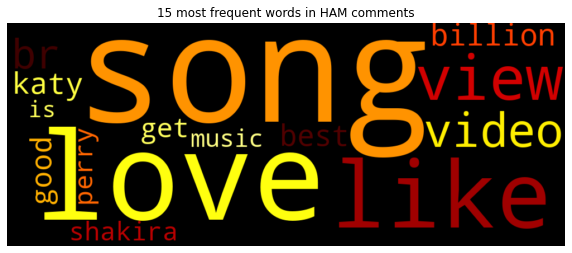

In [48]:
wc=WordCloud(width=1000,height=400,colormap='hot').generate_from_frequencies(frequencies=dict(frequentHamWords[:15]))
plt.imshow(wc, interpolation="bilinear")
plt.title("15 most frequent words in HAM comments")
plt.axis("off");

##### Most frequent words in Spam comments

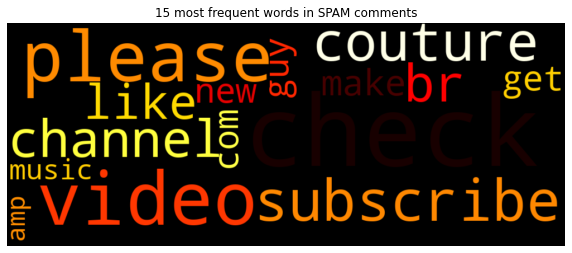

In [49]:
wc=WordCloud(width=1000,height=400,colormap='hot').generate_from_frequencies(frequencies=dict(frequentSpamWords[:15]))
plt.imshow(wc, interpolation="bilinear")
plt.title("15 most frequent words in SPAM comments")
plt.axis("off");

##### Sample words in overlapping categorization

In [50]:
filt=abs(tokenDf['No. of occurances in Ham']-tokenDf['No. of occurances in Spam'])<=5
overlappingWords=tokenDf[filt].reset_index()
overlappingWords=overlappingWords['TokenName'].sample(15,random_state=123)
overlappingWords

2444     teenage
1733        none
991       fruity
1740      norris
189         aunt
1866        pick
1846     perform
1027    generate
85           aka
2242        slip
2251       smile
2006          re
909       female
537         copy
2658        wage
Name: TokenName, dtype: object

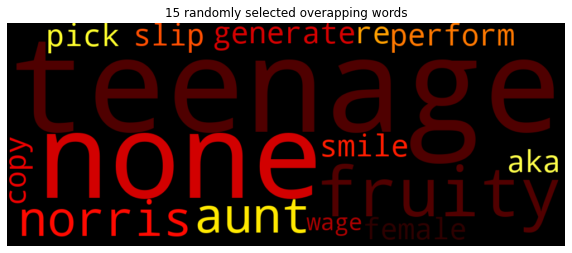

In [51]:
x=' '.join(overlappingWords[:15].to_list())

wc=WordCloud(width=1000,height=400,colormap='hot').generate(x)
plt.imshow(wc, interpolation="bilinear")
plt.title("15 randomly selected overapping words")
plt.axis("off");


#### Grid search multiple models

##### Logistic regression

In [52]:
clf_lr=LogisticRegression()
clf_lr.fit(X_train_dtm.toarray(),y_train)

print('Training score for Logistic Regression: ',clf_lr.score(X_train_dtm.toarray(),y_train))

print('Test score for Logistic Regression: ',clf_lr.score(X_test_dtm.toarray(),y_test))

C:\Users\Preeti\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training score for Logistic Regression:  0.9701492537313433
Test score for Logistic Regression:  0.9333333333333333


##### Random Forest Classifier

In [63]:
clf_rfc = RandomForestClassifier()

param_grid_rfc={'n_jobs':[-1],
            'n_estimators':list(np.arange(3,15,3)), #3,15,2
            'max_depth':list(np.arange(2,5))
           }

gc_rfc=GridSearchCV(clf_rfc,param_grid=param_grid_rfc,cv=cv)

gc_rfc.fit(X_train_dtm.toarray(),y_train)

print('Training score for Random Forest Classifier: ',gc_rfc.score(X_train_dtm.toarray(),y_train))

print('Test score for Random Forest Classifier: ',gc_rfc.score(X_test_dtm.toarray(),y_test))

Training score for Random Forest Classifier:  0.7782515991471215
Test score for Random Forest Classifier:  0.7333333333333333


##### Xgboost Classifier

In [ ]:
clf_xgb = XGBClassifier()

param_grid_xgb={'n_jobs':[-1],
            'n_estimators':[10,20,30,50], 
            'max_depth':list(np.arange(3,30,5))
           }

gc_xgb=GridSearchCV(clf_xgb,param_grid=param_grid_xgb,cv=cv)

gc_xgb.fit(X_train_dtm.toarray(),y_train)

print('Training score for XGB Classifier: ',gc_xgb.score(X_train_dtm.toarray(),y_train))

print('Test score for  XGB Classifier: ',gc_xgb.score(X_test_dtm.toarray(),y_test))

##### Model Comparision

In [ ]:
modelScores={'Model Name':['Logistic Regression',
                       'Random Forest Classifier',
                       'XGBoost Classifier'],
         'Training Score':[clf_lr.score(X_train_dtm.toarray(),y_train),
                          gc_rfc.score(X_train_dtm.toarray(),y_train),
                          gc_xgb.score(X_train_dtm.toarray(),y_train)] ,
         'Testing Score': [clf_lr.score(X_test_dtm.toarray(),y_test),
                          gc_rfc.score(X_test_dtm.toarray(),y_test),
                          gc_xgb.score(X_test_dtm.toarray(),y_test)]}

modelScoresDf=pd.DataFrame(data=modelScores)

modelScoresDf.style.highlight_max(axis=0)